# Training

Plots del entrenamiento, leemos el json del log generado por Transformers.

train_1train_2_train_3_
train_1train_2_train_3_
train_1train_2_train_3_


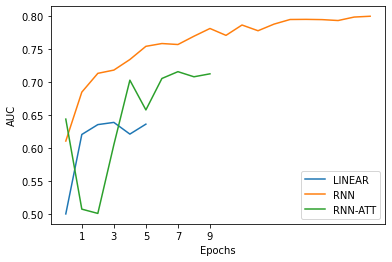

train_4train_5_train_6_
train_4train_5_train_6_
train_4train_5_train_6_


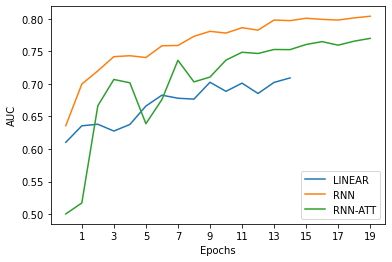

train_7train_8_train_9_
train_7train_8_train_9_
train_7train_8_train_9_


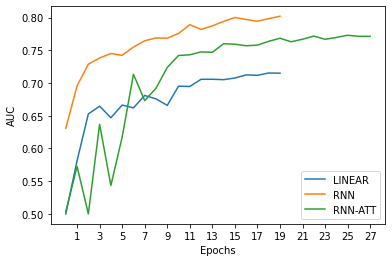

In [4]:

import os
import json
import matplotlib.pyplot as plt
from functools import reduce

def read_checkpoint(folder):
    file_json = open(folder + "/" + "trainer_state.json", "r")
    data_json = json.loads(file_json.read())

    lr_List = []
    acc_List = []
    auc_List = []
    presicion_List = []
    recall_List = []
    fscore_List = []

    for i in range(1, len(data_json["log_history"]), 2):
        lr_List.append(data_json["log_history"][i-1]["learning_rate"])
        acc_List.append(data_json["log_history"][i]["eval_accuracy"])
        auc_List.append(data_json["log_history"][i]["eval_auc"])
        presicion_List.append(data_json["log_history"][i]["eval_precision"])
        recall_List.append(data_json["log_history"][i]["eval_recall"])
        fscore_List.append(data_json["log_history"][i]["eval_f1"])

    return lr_List, acc_List, auc_List, presicion_List, recall_List, fscore_List


def plots(folders):
    for i, folder in enumerate(folders):
        path = "results/" + folder
        checkpoints = os.listdir(path)    
        
        # buscamos el ultimo checkpoint
        checkpoints_id_list = []
        for cp in checkpoints:
            if cp[:10] == "checkpoint":
                checkpoints_id_list.append(int(cp[11:len(cp)]))         
        max_id = max(checkpoints_id_list)

        # leemos las métricas
        lr, acc, auc, presicion, recall, f1 = read_checkpoint(path + "/checkpoint-" + str(max_id))

        # graficamos
        #plt.plot(range(len(auc)),auc, label=folder[:len(folder) -1]) 
        plt.plot(range(len(auc)),auc, label=model_names[i]) 

        plt.xticks(range(1,len(auc), 2))
        plt.legend(loc ="lower right")
        plt.xlabel("Epochs")
        plt.ylabel("AUC")

        tmp = list(map(lambda x: x[:len(x) - 1], folders) )
        name = reduce(lambda a,b: a+b + '_', tmp) 
        print(name)
        plt.savefig('training_' + name , dpi=300)

    plt.show()

#folders = ["train_1/", "train_2/", "train_3/", "train_4/", "train_5/", 
#           "train_6/", "train_7/", "train_8/", "train_9/"]

model_names = ["LINEAR", "RNN", "RNN-ATT"]

plots(["train_1/", "train_2/", "train_3/"] )
plots(["train_4/", "train_5/", "train_6/"] )
plots(["train_7/", "train_8/", "train_9/"] )

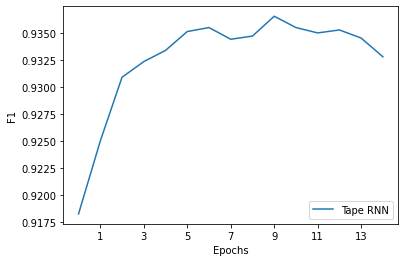

In [21]:
# training plot TAPE 30 epochs

import json
import matplotlib.pyplot as plt

file_json = open("results/train_tape_rnn_freeze_30_epochs/checkpoint-505335/trainer_state.json", "r")
data_json = json.loads(file_json.read())

lr_List = []
acc_List = []
auc_List = []
presicion_List = []
recall_List = []
fscore_List = []

for i in range(1, len(data_json["log_history"]), 2):
    lr_List.append(data_json["log_history"][i-1]["learning_rate"])
    acc_List.append(data_json["log_history"][i]["eval_accuracy"])
    auc_List.append(data_json["log_history"][i]["eval_auc"])
    presicion_List.append(data_json["log_history"][i]["eval_precision"])
    recall_List.append(data_json["log_history"][i]["eval_recall"])
    fscore_List.append(data_json["log_history"][i]["eval_f1"])

plt.plot(range(len(fscore_List)),fscore_List, label="Tape RNN") 

plt.xticks(range(1,len(fscore_List), 2))
plt.legend(loc ="lower right")
plt.xlabel("Epochs")
plt.ylabel("F1")

plt.savefig('training_tape_rnn_freeze_30_epochs', dpi=300)
plt.show()

# Predictions con DB netMHCIIpan3.2

In [3]:
# load model
from model_utils import BertForSequenceClassification, ProteinBertSequenceClsRnnAtt, ProteinBertSequenceClsRnn
from transformers import BertConfig
from transformers import Trainer, TrainingArguments, BertConfig
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from data_loader import My_Load_Dataset

def compute_metrics(pred):
    labels = pred.label_ids
    prediction=pred.predictions
    preds = prediction.argmax(-1)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    sn = tp / (tp + fp)       
    sp = tn / (tn + fp)  # true negative rate
    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sn': sn,
        'sp': sp,
        'accuracy': acc,
        'mcc': mcc
    }

##########################################################################################
model_name = "models/train_6"
model_name = "results/train_6/checkpoint-627"
model_name = "results/train_6/checkpoint-1254"
model_name = "results/train_6/checkpoint-3762"
tokenizer_name = "../models/esm2_t6_8M_UR50D"
tokenizer_name = "../models/esm2_t12_35M_UR50D"
#tokenizer_name = "../models/esm2_t30_150M_UR50D"
##########################################################################################

num_labels = 2
config = BertConfig.from_pretrained(model_name, num_labels=num_labels )
config.rnn = "lstm"
config.num_rnn_layer = 2
config.rnn_dropout = 0.1
config.rnn_hidden = 768
config.length = 51
config.cnn_filters = 512
config.cnn_dropout = 0.1

model = Trainer(   
        #model           = BertForSequenceClassification.from_pretrained(model_name, num_labels=2),  # Funciona bien
        model           = ProteinBertSequenceClsRnn.from_pretrained(model_name, config=config),
        #model           = ProteinBertSequenceClsRnnAtt.from_pretrained(model_name, config=config),    # ProBERT+BiLSTM+Attention
        compute_metrics = compute_metrics,  # evaluation metrics        
    )

test_dataset = My_Load_Dataset(path="../dataset/netMHCIIpan3.2/test_mini.csv", tokenizer_name=tokenizer_name, max_length=71)
predictions, label_ids, metrics = model.predict(test_dataset)
print(metrics)

# train_1 : {'test_loss': 0.6740104556083679, 'test_auc': 0.5, 'test_precision': nan, 'test_recall': 0.0, 'test_f1': nan, 'test_sn': nan, 'test_sp': 1.0, 'test_accuracy': 0.5861940576364584, 'test_mcc': 0.0, 'test_runtime': 8.7386, 'test_samples_per_second': 1536.747, 'test_steps_per_second': 192.136}
# train_2 : {'test_loss': 0.4121377766132355, 'test_auc': 0.8029049642214975, 'test_precision': 0.782048889718231, 'test_recall': 0.7541839121828324, 'test_f1': 0.7678636863319898, 'test_sn': 0.782048889718231, 'test_sp': 0.8516260162601627, 'test_accuracy': 0.8113038945565567, 'test_mcc': 0.609284993618829, 'test_runtime': 23.234, 'test_samples_per_second': 577.989, 'test_steps_per_second': 72.265}
# train_3 : {'test_loss': 0.5812790393829346, 'test_auc': 0.7002468801709116, 'test_precision': 0.6018158236057068, 'test_recall': 0.7514846140003599, 'test_f1': 0.6683738796414852, 'test_sn': 0.6018158236057068, 'test_sp': 0.6490091463414634, 'test_accuracy': 0.6914141038051977, 'test_mcc': 0.39471870123215047, 'test_runtime': 23.9202, 'test_samples_per_second': 561.409, 'test_steps_per_second': 70.192}

# train_4 . {'test_loss': 0.5544854402542114, 'test_auc': 0.7111366783965437, 'test_precision': 0.6540342298288508, 'test_recall': 0.6739247795573151, 'test_f1': 0.6638305415226448, 'test_sn': 0.6540342298288508, 'test_sp': 0.7483485772357723, 'test_accuracy': 0.7175515675031648, 'test_mcc': 0.42053369678328434, 'test_runtime': 13.7501, 'test_samples_per_second': 976.649, 'test_steps_per_second': 122.108}
# train_5 . {'test_loss': 0.4079445004463196, 'test_auc': 0.8070649077886091, 'test_precision': 0.7787303903684787, 'test_recall': 0.7682202627316898, 'test_f1': 0.7734396231542712, 'test_sn': 0.7787303903684787, 'test_sp': 0.8459095528455285, 'test_accuracy': 0.8137612629384169, 'test_mcc': 0.615391936797677, 'test_runtime': 29.0671, 'test_samples_per_second': 462.0, 'test_steps_per_second': 57.763}
# train_6 : {'test_loss': 0.4477434754371643, 'test_auc': 0.7779071039090812, 'test_precision': 0.7617217524980784, 'test_recall': 0.7133345330214145, 'test_f1': 0.7367345042282316, 'test_sn': 0.7617217524980784, 'test_sp': 0.842479674796748, 'test_accuracy': 0.7890386477027329, 'test_mcc': 0.5618958026572887, 'test_runtime': 29.344, 'test_samples_per_second': 457.641, 'test_steps_per_second': 57.218}
# train_6 checkpoint-627:  {'test_loss': 0.6883391737937927, 'test_auc': 0.6417085940277479, 'test_precision': 0.5542205323193916, 'test_recall': 0.6557495051286666, 'test_f1': 0.6007253544345533, 'test_sn': 0.5542205323193916, 'test_sp': 0.6276676829268293, 'test_accuracy': 0.6392881078263459, 'test_mcc': 0.27923444989092516, 'test_runtime': 29.0689, 'test_samples_per_second': 461.972, 'test_steps_per_second': 57.759}
# train_6 checkpoint-1254: {'test_loss': 0.6789227724075317, 'test_auc': 0.6876276954577176, 'test_precision': 0.6702328508495909, 'test_recall': 0.5749505128666547, 'test_f1': 0.6189461449050756, 'test_sn': 0.6702328508495909, 'test_sp': 0.8003048780487805, 'test_accuracy': 0.7070519025988532, 'test_mcc': 0.38624068218330926, 'test_runtime': 28.7226, 'test_samples_per_second': 467.541, 'test_steps_per_second': 58.456}
# train_6 checkpoint-3762: {'test_loss': 0.6644201278686523, 'test_auc': 0.7402086890335342, 'test_precision': 0.652147426134633, 'test_recall': 0.7705596544898327, 'test_f1': 0.7064258021941763, 'test_sn': 0.652147426134633, 'test_sp': 0.7098577235772358, 'test_accuracy': 0.7349765433018095, 'test_mcc': 0.4733408770518752, 'test_runtime': 29.0171, 'test_samples_per_second': 462.795, 'test_steps_per_second': 57.862}

# train_7 : {'test_loss': 0.5093104243278503, 'test_auc': 0.7287161321288173, 'test_precision': 0.7258638743455498, 'test_recall': 0.6237178333633255, 'test_f1': 0.6709252806813784, 'test_sn': 0.7258638743455498, 'test_sp': 0.833714430894309, 'test_accuracy': 0.746816590959863, 'test_mcc': 0.4706460318016841, 'test_runtime': 39.0513, 'test_samples_per_second': 343.881, 'test_steps_per_second': 42.995}
# train_8 : {'test_loss': 0.4066539704799652, 'test_auc': 0.8057577552702152, 'test_precision': 0.7834477639636296, 'test_recall': 0.7597624617599424, 'test_f1': 0.7714233509957975, 'test_sn': 0.7834477639636296, 'test_sp': 0.8517530487804879, 'test_accuracy': 0.8136867972298757, 'test_mcc': 0.6144521977507683, 'test_runtime': 55.7391, 'test_samples_per_second': 240.926, 'test_steps_per_second': 30.122}
# train_9 : {'test_loss': 0.4495180547237396, 'test_auc': 0.7775895226082682, 'test_precision': 0.7609905932040699, 'test_recall': 0.7133345330214145, 'test_f1': 0.7363923462753112, 'test_sn': 0.7609905932040699, 'test_sp': 0.8418445121951219, 'test_accuracy': 0.7886663191600268, 'test_mcc': 0.5611548479982245, 'test_runtime': 55.6932, 'test_samples_per_second': 241.125, 'test_steps_per_second': 30.147}


loading configuration file results/train_6/checkpoint-3762/config.json
Model config BertConfig {
  "_name_or_path": "../models/esm2_t12_35M_UR50D",
  "architectures": [
    "ProteinBertSequenceClsRnnAtt"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "cnn_dropout": 0.1,
  "cnn_filters": 512,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 480,
  "initializer_range": 0.02,
  "intermediate_size": 1920,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "length": 51,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "bert",
  "num_attention_heads": 20,
  "num_hidden_layers": 12,
  "num_rnn_layer": 2,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "rnn": "lstm",
  "rnn_dropout": 0.1,
  "rnn_hidden": 768,
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true

{'test_loss': 0.6644201278686523, 'test_auc': 0.7402086890335342, 'test_precision': 0.652147426134633, 'test_recall': 0.7705596544898327, 'test_f1': 0.7064258021941763, 'test_sn': 0.652147426134633, 'test_sp': 0.7098577235772358, 'test_accuracy': 0.7349765433018095, 'test_mcc': 0.4733408770518752, 'test_runtime': 29.0171, 'test_samples_per_second': 462.795, 'test_steps_per_second': 57.862}


# Prediction Tape (HLAB dataset)

In [7]:
# Predictions for HLAB dataset for TAPE

# load model
from model_utils_tape import TapeRnn
from transformers import BertConfig
from transformers import Trainer, TrainingArguments, BertConfig
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from dataloader_tape import DataSetLoaderTAPE
from tape import ProteinBertConfig

def compute_metrics(pred):
    labels = pred.label_ids
    prediction=pred.predictions
    preds = prediction.argmax(-1)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    sn = tp / (tp + fp)       
    sp = tn / (tn + fp)  # true negative rate
    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sn': sn,
        'sp': sp,
        'accuracy': acc,
        'mcc': mcc
    }

#model_name = "results/train_tape_rnn_freeze/checkpoint-101067"
model_name = "results/train_tape_rnn/checkpoint-101067"
seq_length = 50 # for MHC-I
config = ProteinBertConfig.from_pretrained(model_name, num_labels=2 )

model = Trainer(model = TapeRnn.from_pretrained(model_name, config=config), compute_metrics = compute_metrics)

# lee en orden
test_dataset = DataSetLoaderTAPE("dataset/hlab/hlab_test.csv", max_length=seq_length)

predictions, label_ids, metrics = model.predict(test_dataset)
print(metrics)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 172580
  Batch size = 8
  4%|▎         | 779/21573 [00:15<07:04, 49.00it/s]

KeyboardInterrupt: 

  4%|▎         | 782/21573 [00:29<07:04, 49.00it/s]

: 

# Prediction ESM (HLAB dataset)

In [ ]:
# Predictions for HLAB dataset for ESM
from model_utils_bert import BertRnn
from transformers import BertConfig
from transformers import Trainer, TrainingArguments, BertConfig
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from dataloader_bert import DataSetLoaderBERT
from tape import ProteinBertConfig

def compute_metrics(pred):
    labels = pred.label_ids
    prediction=pred.predictions
    preds = prediction.argmax(-1)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    sn = tp / (tp + fp)       
    sp = tn / (tn + fp)  # true negative rate
    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sn': sn,
        'sp': sp,
        'accuracy': acc,
        'mcc': mcc
    }

#model_name = "results/train_esm2_t30_rnn_freeze/checkpoint-101067"
model_name = "results/train_esm2_t30_rnn/checkpoint-101067"
seq_length = 50 # for MHC-I
config = BertConfig.from_pretrained(model_name, num_labels=2 )

model = Trainer(model = BertRnn.from_pretrained(model_name, config=config), compute_metrics = compute_metrics)

test_dataset = DataSetLoaderBERT("dataset/hlab/hlab_test.csv", tokenizer_name="pre_trained_models/esm2_t6_8M_UR50D", max_length=seq_length)
predictions, label_ids, metrics = model.predict(test_dataset)
print(model_name)
print(metrics)

# esm2 t30 rnn freeze
{'test_loss': 0.1935058832168579, 'test_auc': 0.9302870881826648, 'test_precision': 0.9184688043748447, 'test_recall': 0.9440250841946348, 'test_f1': 0.9310716085582078, 'test_sn': 0.9184688043748447, 'test_sp': 0.916549092170695, 'test_accuracy': 0.9302584308726388, 'test_mcc': 0.8608562206579472, 'test_runtime': 1040.576, 'test_samples_per_second': 165.85, 'test_steps_per_second': 20.732}
# esm2 t30 rnn
{'test_loss': 0.6931536197662354, 'test_auc': 0.5, 'test_precision': 0.4989570054467493, 'test_recall': 1.0, 'test_f1': 0.6657389153040318, 'test_sn': 0.4989570054467493, 'test_sp': 0.0, 'test_accuracy': 0.4989570054467493, 'test_mcc': 0.0, 'test_runtime': 1023.1607, 'test_samples_per_second': 168.673, 'test_steps_per_second': 21.085}
# esm2_t33_rnn_freeze
{'test_loss': 0.5901898741722107, 'test_auc': 0.6816097413302891, 'test_precision': 0.7139173136539464, 'test_recall': 0.604412960167228, 'test_f1': 0.6546172615903203, 'test_sn': 0.7139173136539464, 'test_sp': 0.7588065224933503, 'test_accuracy': 0.6817707729748522, 'test_mcc': 0.36767091882002206, 'test_runtime': 2423.9286, 'test_samples_per_second': 71.198, 'test_steps_per_second': 8.9}

# Prediction ProtBert (HLAB dataset)

In [ ]:
# Predictions for HLAB dataset for ProtBert
from model_utils_bert import BertRnn
from transformers import BertConfig
from transformers import Trainer, TrainingArguments, BertConfig
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from dataloader_bert import DataSetLoaderBERT
from tape import ProteinBertConfig

def compute_metrics(pred):
    labels = pred.label_ids
    prediction=pred.predictions
    preds = prediction.argmax(-1)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    sn = tp / (tp + fp)       
    sp = tn / (tn + fp)  # true negative rate
    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sn': sn,
        'sp': sp,
        'accuracy': acc,
        'mcc': mcc
    }

#model_name = "results/train_protbert_bfd_rnn/checkpoint-101067"
model_name = "results/train_protbert_bfd_rnn_freeze/checkpoint-101067"
seq_length = 50 # for MHC-I
config = BertConfig.from_pretrained(model_name, num_labels=2 )

model = Trainer(model = BertRnn.from_pretrained(model_name, config=config), compute_metrics = compute_metrics)

test_dataset = DataSetLoaderBERT("dataset/hlab/hlab_test.csv", tokenizer_name="pre_trained_models/prot_bert_bfd", max_length=seq_length)
predictions, label_ids, metrics = model.predict(test_dataset)
print(model_name)
print(metrics)

#results/train_protbert_bfd_rnn_freeze/checkpoint-101067
{'test_loss': 0.2328050285577774, 'test_auc': 0.9082794628642646, 'test_precision': 0.9175528438862683, 'test_recall': 0.8968064104052955, 'test_f1': 0.9070610137837474, 'test_sn': 0.9175528438862683, 'test_sp': 0.9197525153232335, 'test_accuracy': 0.9083033955267122, 'test_mcc': 0.8168053301955162, 'test_runtime': 1767.8983, 'test_samples_per_second': 97.619, 'test_steps_per_second': 12.203}

#results/train_protbert_bfd_rnn/checkpoint-101067
{'test_loss': 0.6931493878364563, 'test_auc': 0.5, 'test_precision': 0.4989570054467493, 'test_recall': 1.0, 'test_f1': 0.6657389153040318, 'test_sn': 0.4989570054467493, 'test_sp': 0.0, 'test_accuracy': 0.4989570054467493, 'test_mcc': 0.0, 'test_runtime': 1797.8486, 'test_samples_per_second': 95.993, 'test_steps_per_second': 11.999}


In [ ]:
# save predictions

import pandas as pd

df = pd.DataFrame(predictions)
#print(df)

df['prediction'] = df.apply(lambda row: ( 0 if row[0] > row[1] else 1 ), axis=1)
df['label'] = label_ids
print(df)

df.to_csv("metrics_tape_rnn.csv")

In [ ]:
# compara las métricas optenidas por trainer y obtenidas manualmente. (es lo mismo)
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score

data = pd.read_csv("metrics_tape_rnn.csv", index_col=0)

# tape_rnn_freeze
{'test_loss': 0.18280935287475586, 'test_auc': 0.9345493633791994, 'test_precision': 0.928250864378449, 'test_recall': 0.941574729996516, 'test_f1': 0.9348653260769302, 'test_sn': 0.928250864378449, 'test_sp': 0.9275239967618827, 'test_accuracy': 0.9345347085409665, 'test_mcc': 0.8691619228200305, 'test_runtime': 437.1309, 'test_samples_per_second': 394.802, 'test_steps_per_second': 49.351}

# tape_rnn
{'test_loss': 0.6931484937667847, 'test_auc': 0.5, 'test_precision': 0.4989570054467493, 'test_recall': 1.0, 'test_f1': 0.6657389153040318, 'test_sn': 0.4989570054467493, 'test_sp': 0.0, 'test_accuracy': 0.4989570054467493, 'test_mcc': 0.0, 'test_runtime': 433.9369, 'test_samples_per_second': 397.708, 'test_steps_per_second': 49.715}

acc = accuracy_score(data.label, data.prediction)
tn, fp, fn, tp = confusion_matrix(data.label, data.prediction).ravel()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
auc = roc_auc_score(data.label, data.prediction)
f1 = 2 * (precision * recall) / (precision + recall)

print("acc:", acc, "precision:", precision, "recall:", recall, "auc:", auc, "f1:", f1)

# Prediction NetMHCpan4.1

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score

def get_metrics(label, prediction):
    acc = accuracy_score(label, prediction)
    tn, fp, fn, tp = confusion_matrix(label, prediction).ravel()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    auc = roc_auc_score(label, prediction)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("acc:", acc, "precision:", precision, "recall:", recall, "auc:", auc, "f1:", f1)

data = pd.read_csv("metrics/predictions_netmhcpan4.1.csv")
#print(data)
get_metrics(data.label, data.prediction)

# metricas cuando consideramos al WB (weak binding) como 0 (prediction)
data['prediction2'] = data.apply(lambda row: (  1 if row['ligand'] == "SB" else 0  ), axis=1)
#print(data)
get_metrics(data.label, data.prediction2)

acc: 0.9006895352879823 precision: 0.9585532876803404 recall: 0.8371617698292881 auc: 0.9005572929174196 f1: 0.893754455568298
acc: 0.8312492756982269 precision: 0.9844103296441747 recall: 0.6724422250609685 auc: 0.8309186955072392 f1: 0.7990561025591488
